In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Solve using ODE numeric solver

Define conditions for initial value problem:

-Convert sistem of second order to first order by defining angular and radial velocity.

-Set initial conditions: 1 AU, perihelium is 0, 0 radial velocity at p and angular velocity is 2*pi*1UA

-K is equal to G(MS+MT)~4pi² in AU and solar masses. 

In [87]:
def ODE(t,y):
    K=4*np.pi**2
##equation defined as y'=f(y,t) where y(t)=[r,phi,v,omega] anf f(y,t)=[v,omega,r*omega-K/r^2,-2*v*omega/r]
    return np.array([y[2],y[3],y[0]*y[3]**2-K/y[0]**2,-2*y[2]*y[3]/y[0]])
y0=[1,0,0,2*np.pi]
t= np.linspace(0, 1, 101)

Solve for values in t and store the values

In [88]:
solution =scipy.integrate.solve_ivp(ODE,[t[0],t[-1]],y0,dense_output=True,t_eval=t);
t_values=np.array(solution.t)
y_values=np.array(solution.y)

Plot

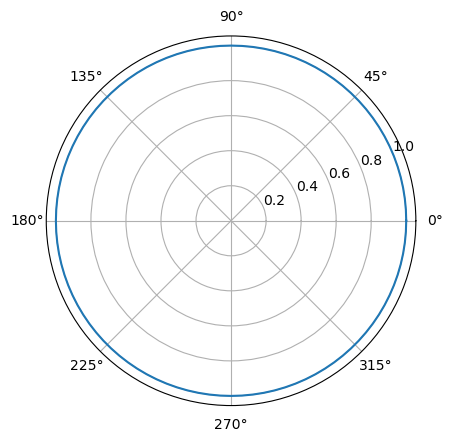

In [89]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(y_values[1,:],y_values[0,:])

## Solve using NN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [ ]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x